In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn')
import datetime
import h5py
import copy
from MC_file import MC

In [10]:
#2D Lattice number
L = 10
#set layer number
Layer_nums=2

# Markov chain warmup
warmup = 2.5e3
# Markov chain total steps
updates = warmup + 5e2

#spin for per Mn atom in MnBi2Te4
S=5/2

#exchange coefficient J/k_b. nearest neighbour lattice
J_intra = S*0.35*1.602e-22/1.381e-23

#Magnetocrystalline Anisotropy Energy
K = S*0.07*1.602e-22/1.381e-23

#exchange coefficient J/k_b. nearest neighbour layer
J_inter=-S*0.088*1.602e-22/1.381e-23

#
data_num = 51

#Magnetic field
#one_uB=5.788*1e-5eV/T
#Apply 1T magnetic field along Z direction
Field = np.linspace(10,-10,data_num)
B=S*(5.788*2*0.01*1.602e-22/1.381e-23)*Field

#Temperature 2K
T = 2

#Initialization spin
data_spin = np.zeros([Layer_nums,L,L,3])

for ee in range(Layer_nums):
	for ii in range(L):
		for jj in range(L):
			
			##Spin Random initialization
			#data_spin[ii,jj,kk,:] = np.random.rand(3)*2-1
			#tmp = data_spin[ii,jj,kk,:]
			#tmp = np.array(tmp)
			#data_spin[ii,jj,kk,:] = tmp/np.sqrt(tmp@tmp)

			#Initialize spin along Z axis
			data_spin[ee,ii,jj,2] = 1.0

In [12]:
%%time
#Store magnetization data for Z axis
Mag_Z=np.zeros(data_num)

#Store magnetization data
Mag = np.zeros(data_num)

# Initailize the Monte carlo parameter, acccept_rate and sigma
acccept_rate = np.ones((int(data_num),int(updates)))*0.0
sigma = np.ones((int(data_num),int(updates)))*60.0

with h5py.File('124_MH.hdf5', 'w') as f:

	for ii in range(data_num):

		counter = 0

		#Record the spin data when Markov chain stochastic process come into steady state
		The_data_spin_collect=[]
		
		mc=MC(Layer_nums=Layer_nums,L=L,J_intra=J_intra,J_inter=J_inter,K=K,B=B[ii],T=T)

		for jj in range(int(updates)): 
			
			tmp = mc.Metropolis(data_spin,acccept_rate[ii,jj],sigma[ii,jj])
			data_spin = tmp[0]

			if jj < int(updates)-1:
				acccept_rate[ii,jj+1] = tmp[1]
				sigma[ii,jj+1] = tmp[2]

			if jj>= warmup: #and jj%2 == 0:

				counter += 1

				#store the spin for Z direction
				The_data_spin_collect.append(copy.deepcopy(data_spin[:,:,:,2]))

				M = mc.Summation(data_spin)
				Mag[ii] += M
	
				M_z=mc.Summation_Z(data_spin)
				Mag_Z[ii]+=M_z
	

		Mag[ii] = Mag[ii]/counter

		Mag_Z[ii]=Mag_Z[ii]/counter

		#store the spin data
		f.create_dataset(str(Field[ii])+'T', data=The_data_spin_collect)

		if ii<=5 or ii%10==0:
			print('{} data_spin_for_{}_T is finishied'.format(datetime.datetime.now(),Field[ii]))

2023-03-03 16:18:39.911832 data_spin_for_10.0_T is finishied
2023-03-03 16:19:23.006289 data_spin_for_9.6_T is finishied
2023-03-03 16:20:07.181745 data_spin_for_9.2_T is finishied
2023-03-03 16:20:51.367210 data_spin_for_8.8_T is finishied
2023-03-03 16:21:36.059139 data_spin_for_8.4_T is finishied
2023-03-03 16:22:20.650977 data_spin_for_8.0_T is finishied
2023-03-03 16:25:57.254448 data_spin_for_6.0_T is finishied
2023-03-03 16:33:01.523856 data_spin_for_2.0_T is finishied
2023-03-03 16:40:16.543193 data_spin_for_-2.0_T is finishied
2023-03-03 16:47:32.646512 data_spin_for_-6.0_T is finishied
2023-03-03 16:54:44.892322 data_spin_for_-10.0_T is finishied
Wall time: 36min 46s


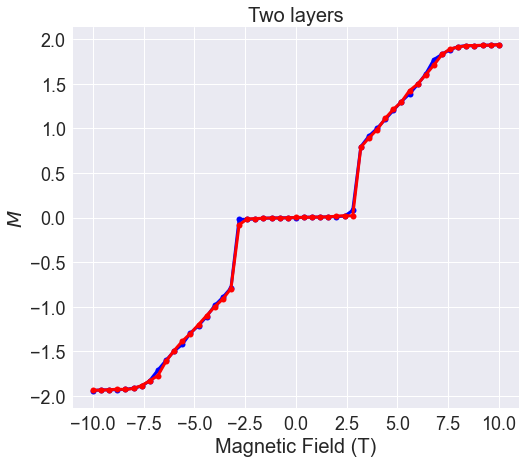

In [15]:
plt.figure(figsize=(8,7))
B_real=np.linspace(10,-10,data_num)
plt.plot(Field,Mag_Z,'bo-',markersize=6,lw=3)
plt.plot(-Field,-Mag_Z,'ro-',markersize=6,lw=3)
plt.xlabel('Magnetic Field (T)',fontsize=20)
plt.ylabel(r'$M$',fontsize=20) 
plt.title('Two layers',fontsize=20)
plt.xlim(-11,11)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

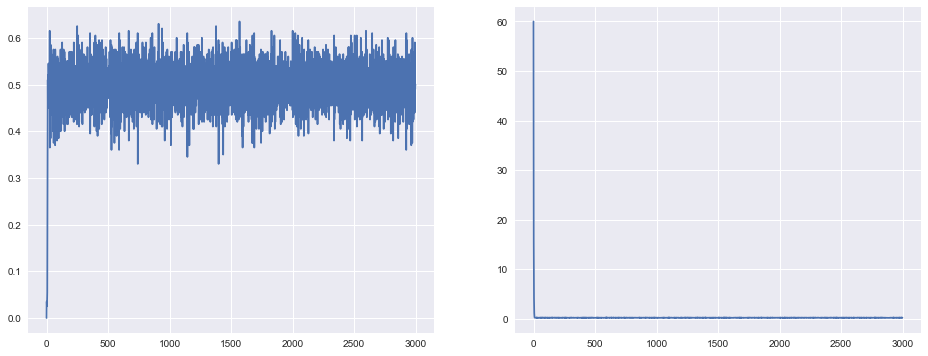

In [21]:
fig = plt.figure(figsize=(16,6))
ii=10
ax1 = plt.subplot(121)
ax1.plot(acccept_rate[ii])

ax2 = plt.subplot(122)
ax2.plot(sigma[ii])
plt.show()